In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split

from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

import statsmodels.tsa.api as tsa

#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

# set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    
### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags == None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df["mean"].plot(ax=ax, color="green", label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(
        forecast_df.index,
        forecast_df["mean_ci_lower"],
        forecast_df["mean_ci_upper"],
        color="green",
        alpha=0.3,
        lw=2,
    )

    # set the title and add legend
    ax.set_title(title)
    ax.legend()

    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, icbest) = tsa.adfuller(ts, **kwargs)
    
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {
        "Test Statistic": test_stat,
        "# of Lags Used": nlags,
        "# of Observations": nobs,
        "p-value": round(pval, 6),
        "alpha": alpha,
        "sig/stationary?": pval < alpha,
    }
    
    return pd.DataFrame(adfuller_results, index=[label])

In [4]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                  acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                  seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict(ls=":", lw=1, zorder=0, color="red")

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="ACF")
        for lag in sig_acf_lags:
            axes[0].axvline(lag, label="sig", **sig_vline_kwargs)

    # PACF
    tsa.graphics.plot_pacf(ts, ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="PACF")
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label="sig", **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags // m

        # Seasonal Lines style
        seas_vline_kwargs = dict(ls="--", lw=1, alpha=0.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons + 1):
            axes[0].axvline(m * i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m * i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config

from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

import statsmodels.tsa.api as tsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import warnings

In [7]:
# Load the dataset
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv"
df = pd.read_csv(url)
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22462,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,NaN,NaN,...,198490.0,198467.0,196420.0,192002.0,191634.0,189383.0,191134.0,191343.0,192384.0,192110.0
22463,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,NaN,NaN,...,229251.0,232984.0,238245.0,240154.0,242470.0,243119.0,249098.0,255572.0,261910.0,264685.0
22464,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,53380.0,53662.0,...,132490.0,134951.0,137470.0,137430.0,137413.0,137615.0,138908.0,140096.0,141573.0,142438.0
22465,249186,28439,Derby Center,city,VT,VT,NaN,Orleans County,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,258191.0,261607.0,264571.0,266255.0


# 1. Load and Preprocess Data

In [8]:
id_vars = df.columns[:8]

In [9]:
full_df = pd.melt(df, id_vars=id_vars, var_name='date', value_name='price')

In [10]:
df.head(3)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0


In [11]:
full_df['date'] = pd.to_datetime(full_df['date'], format='%Y-%m-%d')
df = full_df

In [12]:
# Filter data to include values starting in 2018 based on index
# Filter data to include values starting in 2018 based on index
df = df[df.index >= 2018]
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,date,price
2018,22544,2064,Poulsbo,city,WA,WA,"Bremerton-Silverdale-Port Orchard, WA",Kitsap County,2000-01-31,181255.0
2019,5027,2065,Hackettstown,city,NJ,NJ,"Allentown-Bethlehem-Easton, PA-NJ",Warren County,2000-01-31,177207.0
2020,17382,2066,Chamblee,city,GA,GA,"Atlanta-Sandy Springs-Alpharetta, GA",Dekalb County,2000-01-31,187232.0
2021,398068,2067,De Pere,city,WI,WI,"Green Bay, WI",Brown County,2000-01-31,NaN
2022,19342,2068,Michigan City,city,IN,IN,"Michigan City-La Porte, IN",La Porte County,2000-01-31,NaN
...,...,...,...,...,...,...,...,...,...,...
6133486,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,2022-09-30,192110.0
6133487,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,2022-09-30,264685.0
6133488,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,2022-09-30,142438.0
6133489,249186,28439,Derby Center,city,VT,VT,NaN,Orleans County,2022-09-30,266255.0


In [13]:
# Print the unique dates in your DataFrame
print(df.index.unique())

Int64Index([   2018,    2019,    2020,    2021,    2022,    2023,    2024,
               2025,    2026,    2027,
            ...
            6133481, 6133482, 6133483, 6133484, 6133485, 6133486, 6133487,
            6133488, 6133489, 6133490],
           dtype='int64', length=6131473)


In [14]:
# Assuming you have a separate 'YourDateColumn' column
# df['Date'] = pd.to_datetime(df['Date'])
df.set_index('date', inplace=True)


In [15]:

# Filter data to include values starting in 2018
df = df.loc['2018-01-01':]
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,price
date,,,,,,,,,
2018-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,656700.0
2018-01-31,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,677868.0
2018-01-31,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,178763.0
2018-01-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,254397.0
2018-01-31,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,189921.0
...,...,...,...,...,...,...,...,...,...
2022-09-30,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,192110.0
2022-09-30,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,264685.0
2022-09-30,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,142438.0


In [16]:
df = df[df['RegionName'] == 'New York']

In [17]:
df = df.resample('MS')['price'].mean()

In [18]:
# Check and handle null values if any
df = df.dropna()

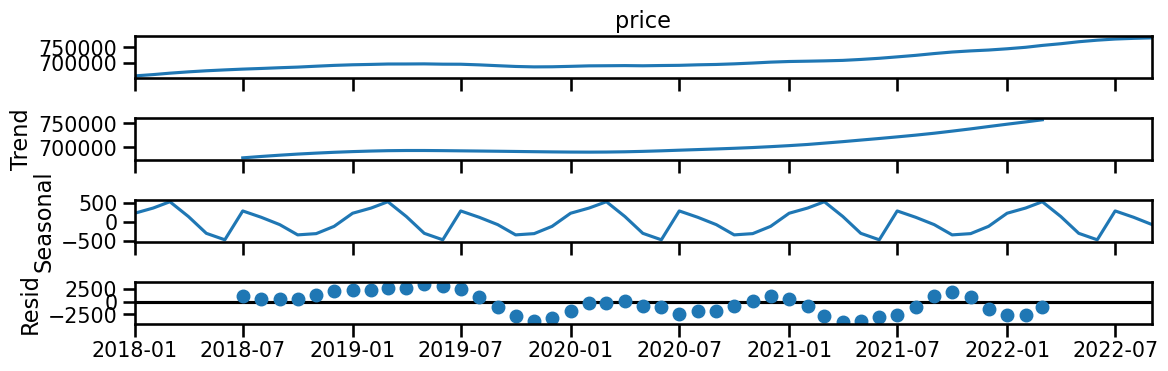

In [19]:
# 2. Decompose Time Series
stl = tsa.seasonal_decompose(df)  # Assuming monthly seasonality
stl.plot();

In [20]:
ndiffs(df)

2

In [21]:
nsdiffs(df, m=12)

0

In [22]:
df_diff = df.diff().diff().dropna()

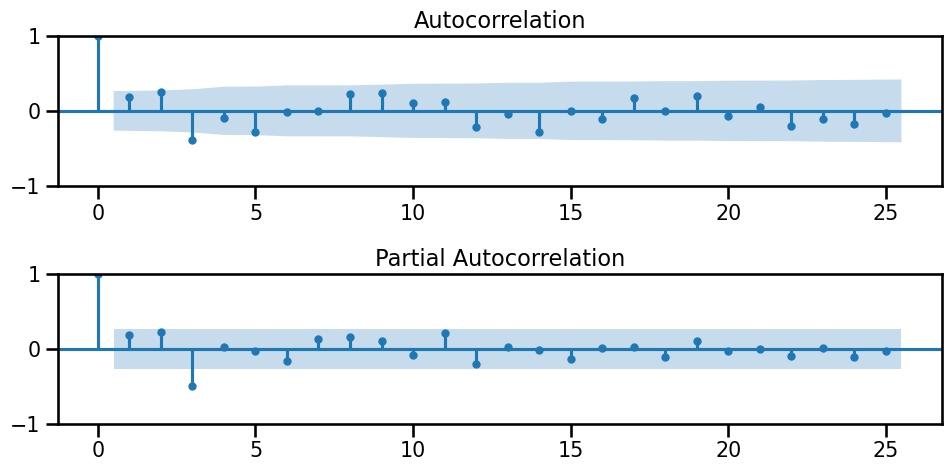

In [23]:
plot_acf_pacf(df_diff, nlags=25);

In [24]:
train, test = train_test_split(df, test_size=6)

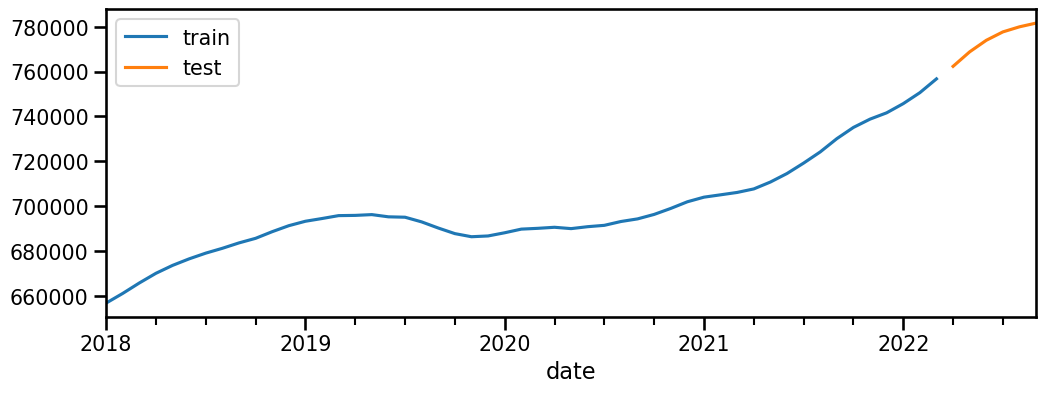

In [25]:
ax= train.plot(label='train')
test.plot ( ax=ax, label = 'test')
ax.legend();

In [38]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 0  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

C:\Users\lidiv\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\lidiv\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                   51
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -479.795
Date:                            Wed, 13 Dec 2023   AIC                            969.589
Time:                                    23:34:08   BIC                            979.248
Sample:                                01-01-2018   HQIC                           973.280
                                     - 03-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.986e+05   1.72e+05      4.055      0.000    3.61e+05    1.04e+06
ar.L1          0.9982      0.016     61.488      0.000       0.966       1.030
ar.S.L12      -0.4362      0.584     -0.748      0.455      -1.580       0.708
ma.S.L12       0.8732      0.711      1.228      0.220      -0.521       2.267
sigma2      6.826e+06   3825.683   1784.153      0.000    6.82e+06    6.83e+06
===================================================================================
Ljung-Box (L1) (Q):                  29.27   Jarque-Bera (JB):                 1.58
Prob(Q):                              0.00   Prob(JB):                         0.45
Heteroskedasticity (H):               1.78   Skew:                            -0.40
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.97e+18. Standard errors may be unstable.
"""

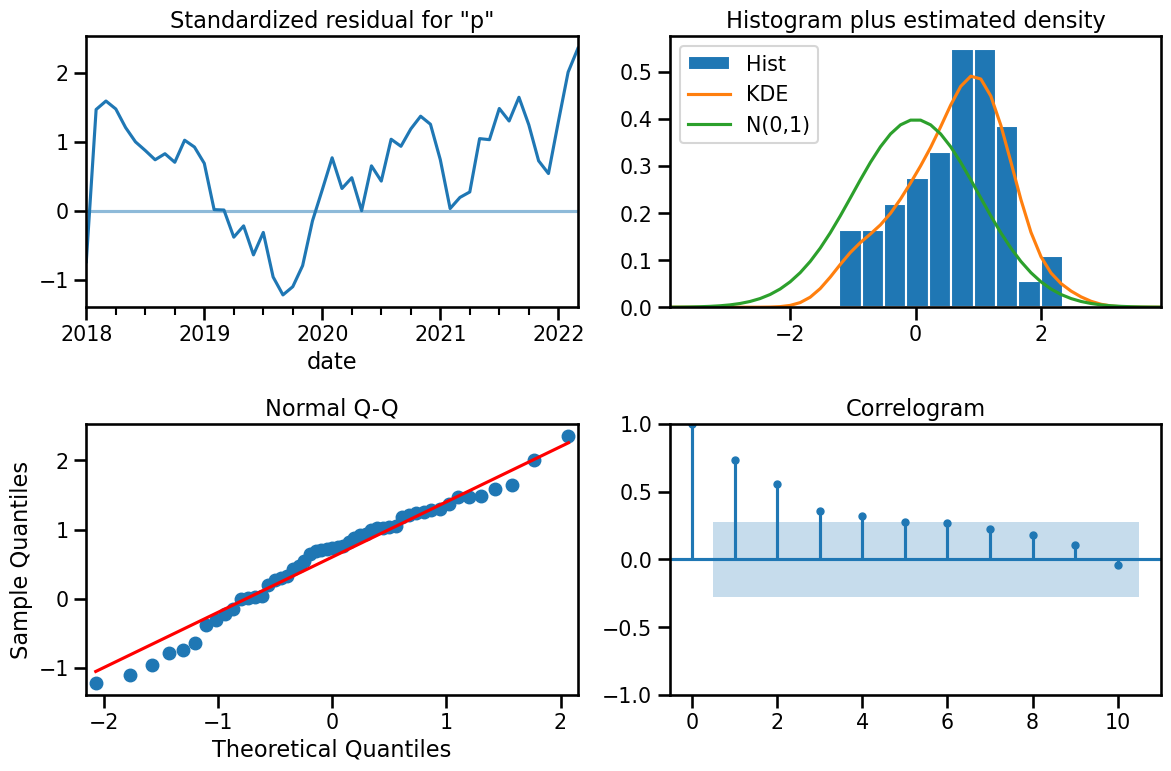

In [39]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(12,8)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 7,019.902
- MSE = 57,406,349.367
- RMSE = 7,576.698
- R^2 = -0.272
- MAPE = 0.90%


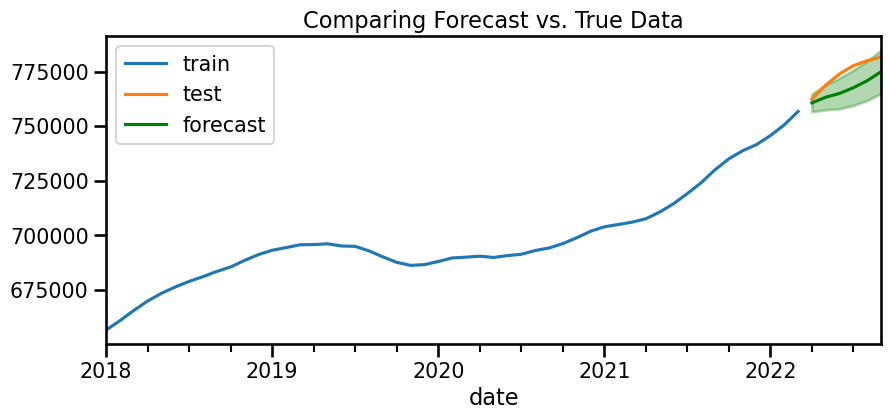

In [28]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [29]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [40]:
# Auto ARIMA Model Tuning
model = pm.auto_arima(train, seasonal=True, m=12, suppress_warnings=True,error_action="ignore")

In [41]:
# Make Predictions
predictions = model.predict(n_periods=len(test))
predictions

2022-04-01    758629.415422
2022-05-01    760502.398223
2022-06-01    762360.241912
2022-07-01    764207.868663
2022-08-01    766048.600306
2022-09-01    767884.678645
Freq: MS, dtype: float64

In [42]:
# Auto ARIMA Model Tuning
auto_model = pm.auto_arima(train, seasonal=True, m=12, suppress_warnings=True, error_action="ignore")

In [43]:
# Get the best parameters
best_order = auto_model.get_params()['order']
best_order

(1, 1, 1)

In [44]:
best_seasonal_order = auto_model.get_params()['seasonal_order']
best_seasonal_order

(0, 0, 0, 12)

In [45]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   51
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -452.947
Date:                Wed, 13 Dec 2023   AIC                            911.895
Time:                        23:35:02   BIC                            917.631
Sample:                    01-01-2018   HQIC                           914.079
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.008    129.821      0.000       0.985       1.015
ma.L1         -0.9997      0.086    -11.632      0.000      -1.168      -0.831
sigma2      4.315e+06   5.79e-09   7.45e+14      0.000    4.32e+06    4.32e+06
===================================================================================
Ljung-Box (L1) (Q):                  39.10   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.00   Prob(JB):                         0.77
Heteroskedasticity (H):               2.15   Skew:                            -0.20
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.13e+29. Standard errors may be unstable.
"""

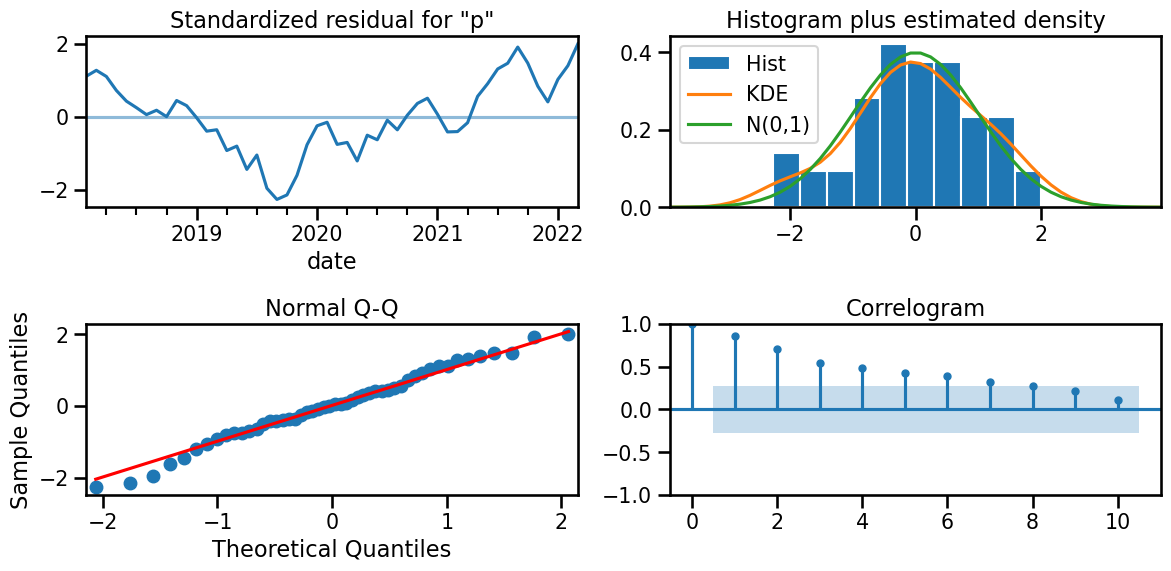

In [46]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(12,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 10,334.760
- MSE = 119,049,338.701
- RMSE = 10,910.973
- R^2 = -1.639
- MAPE = 1.33%


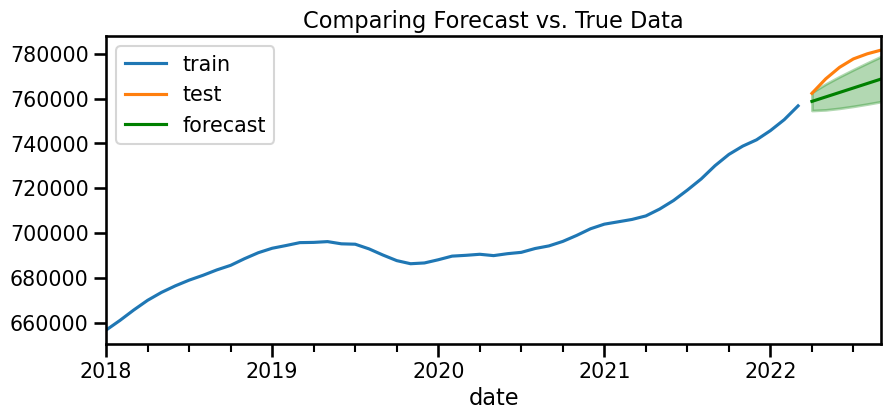

In [47]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

Sarima Manual  is the best choice because :

- The seasonal model follows most  seasonal cycles.
- The seasonal model also has lower AIC score and preferred values for regression metrics

In [49]:
final_p = 0
final_q = 0
final_d = 2
final_P = 0
final_Q = 0
final_D = 0

final_model = tsa.ARIMA(
    df,
    order=(final_p, final_d, final_q),
    seasonal_order=(final_P, final_D, final_Q, m),
).fit()

In [50]:
# Make true future forecasts using the entire dataset
forecast_steps = 12  
forecast = sarima.get_forecast(steps=forecast_steps)
forecast

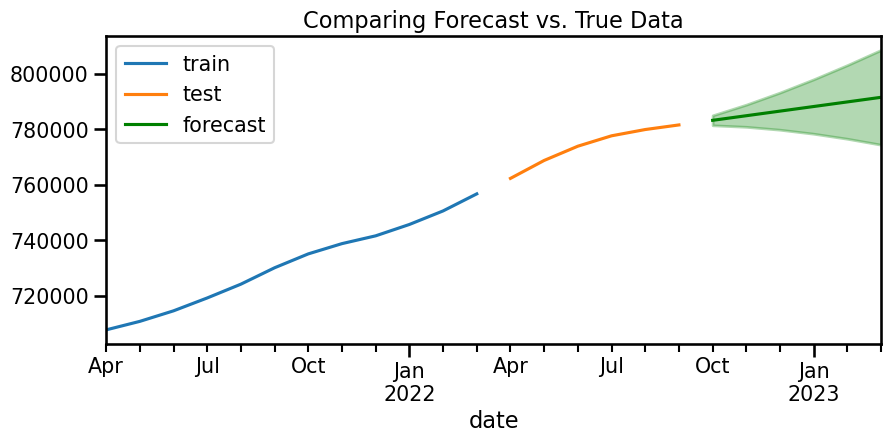

In [51]:
# Ger forecast into true future (fit on entrie time series)
forecast_df = final_model.get_forecast(len(test)).summary_frame()

plot_forecast(train, test, forecast_df, n_train_lags = 12);

In [52]:
# Define starting and final values
starting_value = forecast_df['mean'].iloc[0]
final_value = forecast_df['mean'].iloc[-1]
# Change in x
delta = final_value - starting_value
print(f'The change in X over the forecast is {delta: .2f}.')
perc_change = (delta/starting_value) *100
print (f'The percentage change is {perc_change :.2f}%.')

The change in X over the forecast is  8310.00.
The percentage change is 1.06%.
